In [19]:
%load_ext autoreload
%autoreload 2

from mira.metamodel import *
from mira.modeling.viz import GraphicalModel
from mira.modeling.amr.petrinet import template_model_to_petrinet_json_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
parameters = {
    "theta": Parameter(name="theta"),
    "beta_1": Parameter(name="beta_1", value=0.00025),
    "beta_2": Parameter(name="beta_2", value=0.00006),
    "beta_3": Parameter(name="beta_3", value=0.027),
    "alpha_1": Parameter(name="alpha_1", value=0.2),
    "alpha_2": Parameter(name="alpha_2", value=2.0),
    "phi": Parameter(name="phi", value=2.0),
    "tau": Parameter(name="tau", value=0.52),
    "gama": Parameter(name="gama", value=0.83),
    "mu": Parameter(name="mu"),
    "delta": Parameter(name="delta")
}



susceptible = Concept(name="susceptible",
                            identifiers={"ido": "0000514"},
                            # context={"species": "ncbitaxon:9606"}
                     )
exposed = Concept(name="exposed", identifiers={"ido": "0000597"},
                        # context={"species": "ncbitaxon:9606"}
                 )
infected = Concept(name="infected", identifiers={"ido": "0000511"},
                         # context={"species": "ncbitaxon:9606"}
                  )
quarantined = Concept(name="quarantined",
                            # context={"species": "ncbitaxon:9606"}
                     )
recovered = Concept(name="recovered",
                          identifiers={"ido": "0000592"},
                          # context={"species": "ncbitaxon:9606"}
                   )


exposure_rate_str = "(beta_1*infected + beta_2*infected)*susceptible/(susceptible+exposed+infected+quarantined+recovered)"

produce_susceptible = NaturalProduction(outcome=susceptible, rate_law = safe_parse_expr("theta"))
degradate_susceptible = NaturalDegradation(subject=susceptible, rate_law=safe_parse_expr("mu"))
degradate_exposed = NaturalDegradation(subject=exposed, rate_law=safe_parse_expr("mu"))
degradate_infected = NaturalDegradation(subject=infected, rate_law=safe_parse_expr("mu+delta"))

exposure = ControlledConversion(
    name="exposure_template",
    subject=susceptible,
    outcome=exposed,
    controller=infected,
    rate_law=safe_parse_expr(exposure_rate_str)
)


infection = NaturalConversion(
    subject=exposed, outcome=infected,
    rate_law=safe_parse_expr("alpha_1")
)


exposure_to_quarantine = NaturalConversion(
    subject=exposed,
    outcome=quarantined,
    rate_law=safe_parse_expr("alpha_2")
)
recovery = NaturalConversion(
    subject=infected, outcome=recovered,
    rate_law=safe_parse_expr("gama")
)

quarantine_to_susceptible = NaturalConversion(
    subject=quarantined, outcome=susceptible,
    rate_law=safe_parse_expr("theta")
)

templates = [produce_susceptible, degradate_susceptible, degradate_exposed, degradate_infected, exposure, infection, exposure_to_quarantine,
             recovery, quarantine_to_susceptible]


old_templates = [
    exposure,
    infection,
    exposure_to_quarantine,
    recovery,
    quarantine_to_susceptible,
]


tm = TemplateModel(templates=templates, parameters=parameters)


strata=["human", "rodent"]
strata_curie_to_name = {"ncbitaxon:9606":"human", "ncbitaxon:9989":"rodent"}
concepts_to_stratify = [susceptible.name, exposed.name, infected.name]
params_to_stratify = ["theta", "mu", "delta"]


tm = stratify(
    tm,
    key="species",
    strata=strata,
    strata_curie_to_name=strata_curie_to_name,
    params_to_stratify=params_to_stratify,
    concepts_to_stratify=concepts_to_stratify,
    directed=True
)

new_param_values = {
    "theta_0": 0.029,
    "theta_1": 0.2,
    "mu_0": 1.5,
    "mu_1": .002,
    "delta_0": .2,
    "delta_1": .5
}

tm.set_parameters(new_param_values)

In [21]:
# Remove illegial templates 

template_indicies_to_remove = [] 
for index, template in enumerate(tm.templates):
    if hasattr(template,"subject") and hasattr(template,"outcome"):
        if "rodent" in template.subject.name and "quarantined" == template.outcome.name:
            template_indicies_to_remove.append(index)
        elif "rodent" in template.outcome.name and "quarantined" == template.subject.name:
            template_indicies_to_remove.append(index)
        elif "rodent" in template.subject.name and "recovered" == template.outcome.name:
            template_indicies_to_remove.append(index)
        elif "rodent" in template.outcome.name and "recovered" == template.subject.name:
            template_indicies_to_remove.append(index)
        elif "rodent" in template.subject.name and "human" in template.outcome.name:
            template_indicies_to_remove.append(index)
        elif "rodent" in template.outcome.name and "human" in template.subject.name:
            template_indicies_to_remove.append(index)

new_templates = [] 
for index,template in enumerate(tm.templates):
    if index not in template_indicies_to_remove:
        new_templates.append(template)
tm.templates = new_templates        


In [22]:
# Add templates from human only compartments to rodent compartments 

recovered_human_to_susceptible_rodent = NaturalConversion(
    subject=recovered, outcome=tm.get_concept("susceptible_rodent"), rate_law=safe_parse_expr("mu_0")
)

susceptible_rodent_to_exposed_rodent = NaturalConversion(
    subject=quarantined, outcome=tm.get_concept("exposed_rodent"), rate_law=safe_parse_expr("mu_0+delta_0")
)


tm.templates.append(recovered_human_to_susceptible_rodent)
tm.templates.append(susceptible_rodent_to_exposed_rodent)


In [23]:
# Rewrite rate laws when necessary
for template in tm.templates:
    if template.name == "exposure_template_human":
        template.rate_law = safe_parse_expr("susceptible_human*(beta_1*infected_rodent + beta_2*infected_human)/(exposed_human + infected_human + quarantined + recovered + susceptible_human)")
    if template.name == "exposure_template_rodent":
        template.rate_law = safe_parse_expr("infected_rodent*beta_3*susceptible_rodent/(susceptible_rodent+exposed_rodent+infected_rodent)")

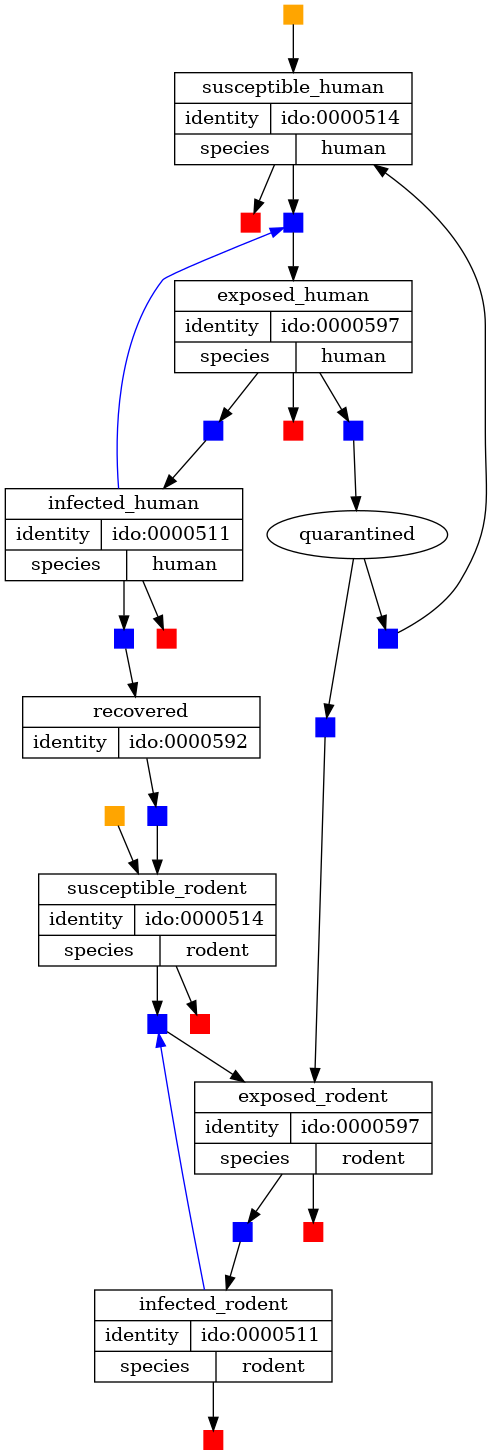

In [24]:
GraphicalModel.for_jupyter(tm, width=700, height=1000)

In [25]:
template_model_to_petrinet_json_file(tm, "modelB_base_petri.json")